In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base= automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)
classes = Base.classes.keys()

In [8]:
# We can view all of the classes that automap found

classes

['measurement', 'station']

In [9]:
# Save references to each table
Measurement= Base.classes.measurement
Station= Base.classes.station 

In [10]:
# Create our session (link) from Python to the DB

session= Session(bind=engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#TODO
last_year= dt.date(2017,8,23) - dt.timedelta(days = 365)

last_year_data= session.query(Measurement.date, Measurement.prcp).\
    filter( Measurement.date >= dt.datetime.strftime(last_year,"%Y-%m-%d")).\
    filter(Measurement.prcp.isnot(None)).order_by(Measurement.date.desc()).\
    all()

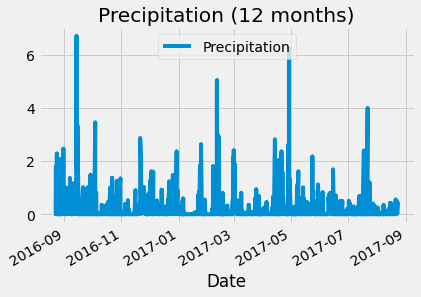

In [12]:
df= pd.DataFrame(last_year_data, columns=["Date", "Precipitation"])
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
df.set_index("Date", inplace=True)
df = df.sort_values(by="Date", ascending=True)
df.plot(title= "Precipitation (12 months)")
plt.legend(loc="upper center")
plt.savefig("Images/Precipitation.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?

available_stations= session.query(Measurement.station).distinct().count()
available_stations

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations= session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max=session.query(func.max(Measurement.tobs)).all()
min=session.query(func.min(Measurement.tobs)).all()
avg=session.query(func.avg(Measurement.tobs)).all()
count=session.query(func.count(Measurement.tobs)).all()
print(f"The highest number of observations:{max[0]}, The lowest number of observations: {min[0]}, The average number of observations: {avg[0]} and The number of observations: {count[0]}")

The highest number of observations:(87.0,), The lowest number of observations: (53.0,), The average number of observations: (73.09795396419437,) and The number of observations: (19550,)


In [17]:
most_active_station= session.query(Measurement.station, Station.name, func.count(Station.id)).\
    filter(Measurement.station == Station.station).\
    group_by(Station.station, Station.name).\
    order_by(func.count(Station.id).desc()).\
    first()

most_active_station

('USC00519281', 'WAIHEE 837.5, HI US', 2772)

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data= session.query(Measurement.tobs).\
    filter(Measurement.date>= last_year).\
    filter(Measurement.station == most_active_station[0]).\
    order_by(Measurement.date).all()

In [19]:
temp_obs_df= pd.DataFrame(tobs_data, columns=["Tobs"])
temp_obs_df.head()

,Tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


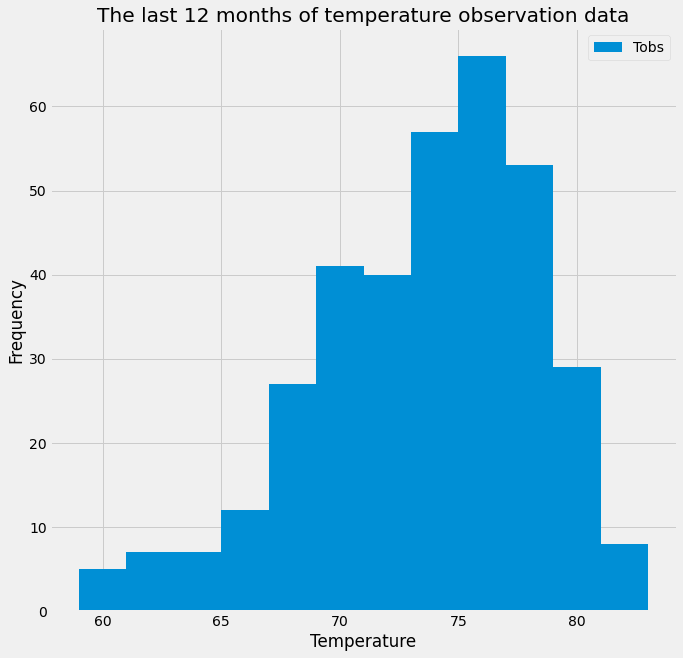

In [20]:
temp_obs_df.plot.hist(bins=12, title="The last 12 months of temperature observation data", figsize=(10,10))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.savefig("./Images/last_12_months_temperature_observation_data")
plt.show()

## Bonus Challenge Assignment

In [21]:
# H0 : There is no difference betweeen average temperature of June and December
# H1: There is difference betweeen average temperature of June and December

In [22]:
avg_temp_June= session.query(func.strftime("%Y-%m", Measurement.date), func.avg(Measurement.tobs)).\
    filter(func.strftime("%m",Measurement.date) == '06').\
    group_by(func.strftime("%Y", Measurement.date)).\
    all()

avg_temp_June

[('2010-06', 74.92561983471074),
 ('2011-06', 73.93832599118943),
 ('2012-06', 74.0),
 ('2013-06', 74.59907834101382),
 ('2014-06', 75.02790697674419),
 ('2015-06', 74.99014778325123),
 ('2016-06', 75.17525773195877),
 ('2017-06', 77.21989528795811)]

In [23]:
avg_temp_Dec= session.query(func.strftime("%Y-%m", Measurement.date), func.avg(Measurement.tobs)).\
    filter(func.strftime("%m",Measurement.date) == '12').\
    group_by(func.strftime("%Y", Measurement.date)).\
    all()

avg_temp_Dec

[('2010-12', 70.20851063829787),
 ('2011-12', 70.82062780269058),
 ('2012-12', 71.18807339449542),
 ('2013-12', 71.09401709401709),
 ('2014-12', 69.89686098654708),
 ('2015-12', 73.42391304347827),
 ('2016-12', 71.13)]

In [24]:
june= [temp[1] for temp in avg_temp_June]
dec= [temp[1] for temp in avg_temp_Dec]

In [25]:
from scipy import stats
p_value , t_test = stats.ttest_ind(june, dec)
p_value = "{:.10f}".format(p_value)
print(f"t: {t_test}      p: {p_value}")

t: 9.681543069110451e-06      p: 6.9760523779


In [26]:
# p_value (6.97) is more than 0.05 so we can't reject the H0 and we conclude that there is no difference betweeen average temperature of June and December
# It's an unpaired or independent t-test  due to comparing the averages/means of two independent or unrelated groups.

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:dd
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip= calc_temps("2017-07-01", "2017-07-14")
trip

[(69.0, 78.11627906976744, 87.0)]

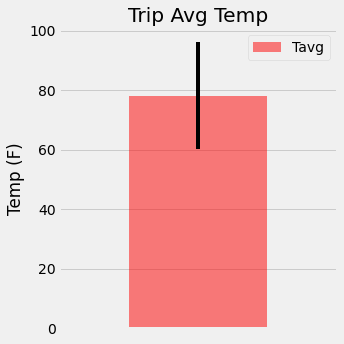

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df= pd.DataFrame(trip, columns=["Tmin","Tavg","Tmax"])
trip_df.plot.bar(y="Tavg", yerr = (trip_df["Tmax"]- trip_df["Tmin"]), title="Trip Avg Temp", color= "red", alpha= 0.5, figsize=(5,5))
plt.ylabel("Temp (F)")
plt.xticks(np.arange(1,1.0))

# Save the figure and show
plt.tight_layout()
plt.savefig("./Images/trip_avg_temp.png")
plt.show()

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_precipitation(start_date, end_date):
    sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp]

    return session.query(*sel).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).\
        group_by(Measurement.station).\
        order_by(Measurement.prcp.desc()).all()

precipitation = calc_precipitation("2017-07-01", "2017-07-14")

prec_df = pd.DataFrame(precipitation, columns = ["Station", "Name", "Rainfall", "Latitude", "Longitude", "Elevation"])
prec_df



,Station,Name,Rainfall,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.10
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.08
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.02
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,NaN
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,NaN


In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def get_daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
get_daily_normals("07-01")

[(67.0, 74.77777777777777, 81.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


start_date= "2017-07-01"
end_date= "2017-07-14"
normals=[]
dates= session.query(Measurement.date).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Measurement.date).\
    all()
 
trip_dates = [date[0] for date in dates]

trip_dates_stripped= [date[5:] for date in trip_dates]

start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]

daily_normals = [session.query(func.min(Measurement.tobs),
    func.avg(Measurement.tobs),
    func.max(Measurement.tobs)).\
    filter(func.strftime("%m-%d", Measurement.date)>= start_month_day).\
    filter(func.strftime("%m-%d", Measurement.date)<=end_month_day).\
    group_by(func.strftime("%m-%d", Measurement.date)).\
    all()]

daily_normals = daily_normals[0]
print(f"Summarize Daily Normals for 07-01 to 07-14")
daily_normals


Summarize Daily Normals for 07-01 to 07-14


[(67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0)]

In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df= pd.DataFrame(daily_normals, columns=["tmin", "tavg", "tmax"])
daily_normals_df["date"] = trip_dates
daily_normals_df["date"] = pd.to_datetime(daily_normals_df["date"], format= "%Y-%m-%d")
daily_normals_df.set_index("date", inplace= True)
daily_normals_df

,tmin,tavg,tmax
date,,,
2017-07-01,67.0,74.777778,81.0
2017-07-02,68.0,75.403846,82.0
2017-07-03,68.0,75.320755,87.0
2017-07-04,70.0,76.571429,81.0
2017-07-05,66.0,75.000000,81.0
2017-07-06,69.0,75.000000,81.0
2017-07-07,69.0,74.910714,82.0
2017-07-08,69.0,76.083333,83.0
2017-07-09,68.0,76.192982,83.0


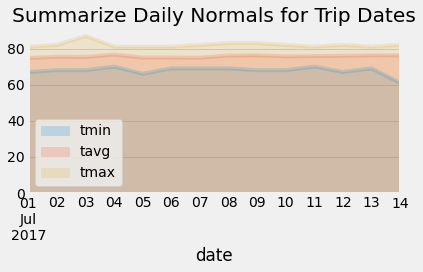

In [34]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind = "area", alpha=0.2, stacked=False, title="Summarize Daily Normals for Trip Dates")
plt.tight_layout()
plt.savefig("./Images/daily_normals_trips.png")
plt.show()

In [35]:
session.close()